### Background:

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

### Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

### Goal:

Predict if the page is being flipped using a single image.

### Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

### Bonus:

Predict if a given sequence of images contains an action of flipping.

### Importing Libraries

In [1]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import tensorflow packages
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import he_uniform

# from medium
import keras.backend as K

# Import prebuilt models
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Set pyplot parameters
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


### Loading the data

In [2]:
# Set folders pathes that contain image files 
train_dir = "../content/drive/MyDrive/images/training"
test_dir = "../content/drive/MyDrive/images/testing"

To read images and labeling them I used keras's preprocessing tool `image_dataset_from_directory`. It automatically reads all the image files, decodes them and label them depending on folder images were in. Shuffling and image resizing is also performed within function.

I know that images have dimension of [1920x1080], and it is necessary to scale it down. Otherwise the model will be too big with too many parameters to train. The new image sizes will be decreased six fold to [320x180]. Also data will be given to model in batches of 32. 

In [3]:
# Set parameters for decoding images
img_size = (320,180)
batch_size = 32

# Create training and testing datasets. Label mode is binary as we have only two options
train_list_ds = image_dataset_from_directory(train_dir, label_mode = 'binary', 
                                             image_size = img_size, batch_size = batch_size)

test_list_ds = image_dataset_from_directory(test_dir, label_mode = 'binary', 
                                            image_size = img_size, batch_size = batch_size)

Found 2392 files belonging to 2 classes.
Found 597 files belonging to 2 classes.


Check if labels are correct:

In [4]:
# print class names of dataset
print(train_list_ds.class_names)

['flip', 'notflip']


Training and testing sets with their according labels are created. Next step is to create model that can process given images and detect if page is being flipped. 


### Creating the model

This task is quite straight forward, so it does not require complicated models. I decided to build a model that consists of three stages of convolutional and maxpooling layers, followed by three fully connected layers.


The following figure describes in detail the architecture of this neural network.


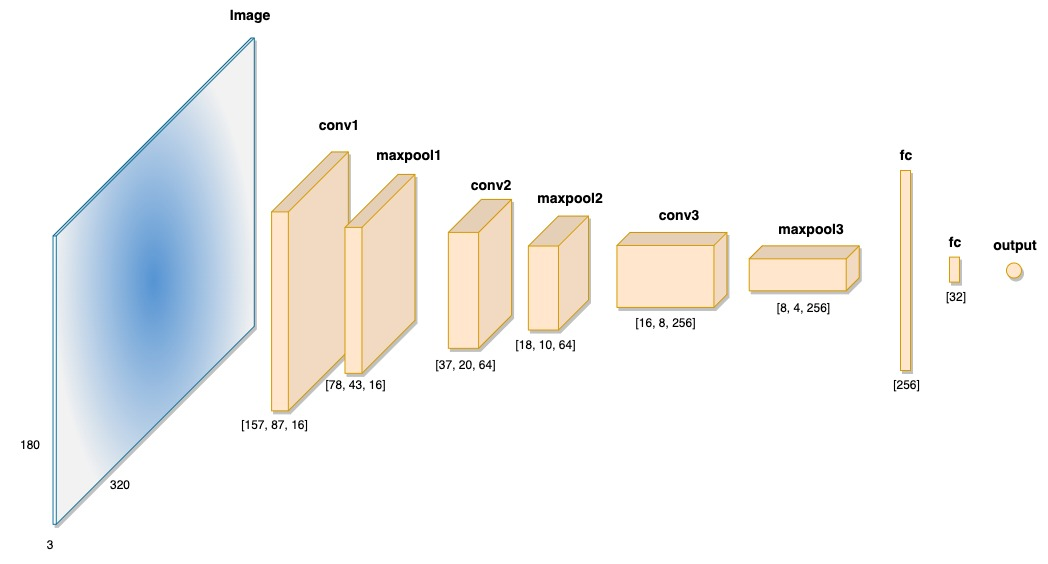




`INPUT -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE -> DENSE -> DENSE`

Details of the model:
- The Input layer.
- Stage 1:
 - The 2D Convolution has 16 filters of shape (7,7) and uses a stride of (2,2).
 - BatchNormaliztion is applied and ReLU activation is applied.
 - MaxPooling uses a filter of shape(3,3) and a (2,2) stride.

- Stage 2:
 - The 2D Convolution has 64 filters of shape (5,5) and uses a stride of (2,2).
 - BatchNormaliztion is applied and ReLU activation is applied.
 - MaxPooling uses a filter of shape(2,2) and a (2,2) stride.

- Stage 3:
 - The 2D Convolution has 256 filters of shape (3,3) and uses a stride of (1,1).
 - BatchNormaliztion is applied and ReLU activation is applied.
 - MaxPooling uses a filter of shape(2,2) and a (2,2) stride.

- Stage 4:
 - The Flatten layer to flatten output of Stage 3 convolution layer.
 - Two Fully Connected (Dense) layers reduce input to 32 parameters using relu activation.
 - The output - Fully Connected layer reduces to single binary value using sigmoid activation. 

All of the layers' weights in the model are initialized using *he_uniform*. 

In [5]:
# Create the model
def cnn(input_size = (320, 180, 3)):

  inputs = Input(input_size)

  # Stage 1 Conv2d and MaxPool - 16
  X = Conv2D(16, (7, 7), strides = (2, 2), kernel_initializer = he_uniform())(inputs)
  X = BatchNormalization(axis = 3)(X)
  # X = ReLU(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  # stage 2 Conv2d and MaxPool - 64
  X = Conv2D(64, (5, 5), strides = (2, 2), kernel_initializer = he_uniform())(X)
  X = BatchNormalization(axis = 3)(X)
  # X = ReLU(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 2), strides=(2, 2))(X)

  # Stage 3 Conv2d and MaxPool - 64
  X = Conv2D(256, (3, 3), strides = (1, 1), kernel_initializer = he_uniform())(X)
  X = BatchNormalization(axis = 3)(X)
  # X = ReLU(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 2), strides=(2, 2))(X)

  # Stage 4 FC
  X = Flatten()(X)
  X = Dense(256, activation='relu', kernel_initializer = he_uniform())(X)
  X = Dense(32, activation='relu', kernel_initializer = he_uniform())(X)
  outputs = Dense(1, activation='sigmoid', kernel_initializer = he_uniform())(X)

  model = Model(inputs = inputs, outputs = outputs)
  
  return model

### Creating f1-score metric for keras
As success metrics for this project requires using f1 score, I need to write a code for calculation of f1 score in keras. 
By default, f1 score is not part of keras metrics and hence we can’t just directly write f1 score in metrics while compiling model and get results.
The function for f1-score calculation is written using data from keras.backend. 
I used the article from [medium](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d) to write this function.

In [4]:
# Function to calculate f1 score. Keras's backend is used as K
def f1_score(y_true, y_pred): 
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tp_fn = K.sum(K.round(K.clip(y_true, 0, 1)))
    tp_fp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (tp_fp + K.epsilon())
    recall = tp / (tp_fn + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1

Next step is to set model dimensions and initialize the model. Adam optimizer is used in this model, as well as a binary crossentropy for loss calculation. For metrics of model evaluation accuracy and f1-scores are chosen as per project requirement.  
Model summary is also checked to see if all dimensions are correct and all layers are in place.

In [7]:
# Initialize the model
model = cnn((320, 180, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Print model summary
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 157, 87, 16)       2368      
                                                                 
 batch_normalization (BatchN  (None, 157, 87, 16)      64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 157, 87, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 43, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 20, 64)        25664 

Model summary indicates that all the parameters were created as planned and there are 2.28 million trainable parameters in the model. Next step is to train the model to training set for ten epochs.

In [8]:
history = model.fit(train_list_ds, epochs = 10)

Epoch 1/10
75/75 [==============================] - 226s 2s/step - loss: 0.4798 - accuracy: 0.8528 - f1_score: 0.8410
Epoch 2/10
75/75 [==============================] - 19s 224ms/step - loss: 0.1001 - accuracy: 0.9636 - f1_score: 0.9631
Epoch 3/10
75/75 [==============================] - 19s 226ms/step - loss: 0.0409 - accuracy: 0.9883 - f1_score: 0.9878
Epoch 4/10
75/75 [==============================] - 19s 223ms/step - loss: 0.0424 - accuracy: 0.9879 - f1_score: 0.9882
Epoch 5/10
75/75 [==============================] - 19s 224ms/step - loss: 0.0221 - accuracy: 0.9933 - f1_score: 0.9929
Epoch 6/10
75/75 [==============================] - 19s 224ms/step - loss: 0.0716 - accuracy: 0.9707 - f1_score: 0.9704
Epoch 7/10
75/75 [==============================] - 19s 224ms/step - loss: 0.0089 - accuracy: 0.9975 - f1_score: 0.9974
Epoch 8/10
75/75 [==============================] - 19s 223ms/step - loss: 5.1948e-04 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 9/10
75/75 [====================

In [9]:
model.evaluate(test_list_ds)

19/19 [==============================] - 67s 2s/step - loss: 0.0047 - accuracy: 0.9983 - f1_score: 0.9986


[0.004714563954621553, 0.9983249306678772, 0.9985775351524353]

Implementing three convolutional layers resulted in high accuracy and f1-score performance on test set. Accuracy the model could reach on 10 epochs is 0.9983 while f1-score is 0.9986. I believe these scores are very high and no more further tuning is required.

### Prebuilt models ResNet
Next step is to test how existing classic networks will perform on this task. I chose ResNet50 for this project as I have experience with this network. It has about 25 million parameters and top-1 accuracy of the model is ~ 75%. The ResNet model in this project will be used by transfer learning, using the trained weights of "imagenet" database.

Residual neural networks utilize skip connections, or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. There are two main reasons to add skip connections: to avoid the problem of vanishing gradients, or to mitigate the Degradation (accuracy saturation) problem; where adding more layers to a suitably deep model leads to higher training error. During training, the weights adapt to mute the upstream layer, and amplify the previously-skipped layer. Skipping effectively simplifies the network, using fewer layers in the initial training stages. This speeds learning by reducing the impact of vanishing gradients, as there are fewer layers to propagate through. (https://en.wikipedia.org/wiki/Residual_neural_network)

The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

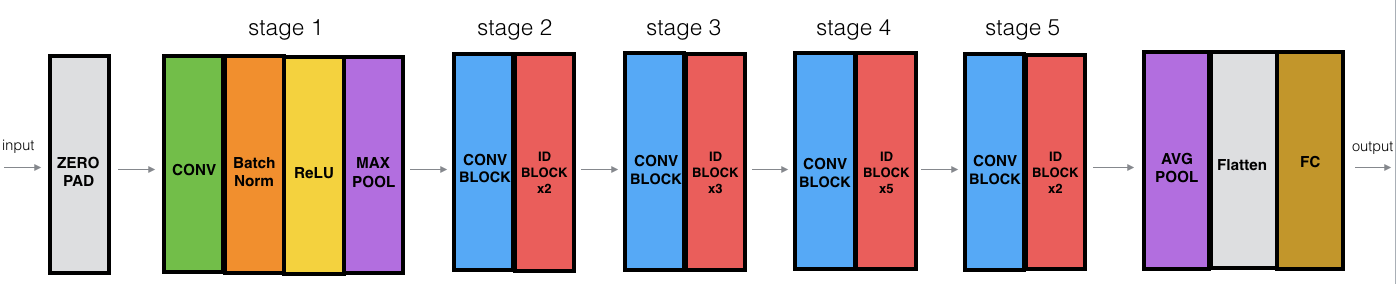

For this part of the project sequential model is used, where pretrained ResNet50 model and dense layers were put in sequence. In pretrained model the input shape is defined and `include_top` pareameter is set to *False* as  the shape of input and putput layers of mode are changed. It is also necessary to set trainable parameter of all layers of pretrained ResNet model to False. This way weights are not changed during the training process. This model is already trained and only final dense layers are fitted.

Pooling after the main model is set to average, as plotted in the graph above. Afterwards the output of the model is flattened and data then flows into fully connected layer consisting of 512 units. The final output layer is binary output with 'sigmoid' activation function.

In [13]:
# Create sequential model
resnet_model = Sequential()

# Get prebuilt ResNet model with 'imagenet' weights
pretrained_model = ResNet50V2(include_top = False, weights = 'imagenet', input_shape = (320, 180, 3), pooling = 'avg')

# Set layers of ResNet to 'untrainable' mode
for layer in pretrained_model.layers:
  layer.trainable = False

# Add pretrained part to my model
resnet_model.add(pretrained_model)

# Add flatten and fully connected layers
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

94683136/94668760 [==============================] - 0s 0us/step


In [14]:
# Print summary of the model
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,614,401
Trainable params: 1,049,601
Non-trainable params: 23,564,800
_________________________________________________________________


There are ~1 million trainibel parameters in this model, while 24.6 million parameters are non-trainable. These non-trainable parameters are the ones that came with prebuilt ResNet model and are trained on "Imagenet" database. Adam optimizer is used in this model, as well as a binary crossentropy for loss calculation. For metrics of model evaluation accuracy and f1-scores are chosen as per project requirement.

In [15]:
# Compile the model
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

In [16]:
# Fit the model to training set
history_resnet = resnet_model.fit(train_list_ds, epochs = 30)

Epoch 1/30
75/75 [==============================] - 26s 257ms/step - loss: 31.1171 - accuracy: 0.5468 - f1_score: 0.4559
Epoch 2/30
75/75 [==============================] - 20s 240ms/step - loss: 4.3475 - accuracy: 0.6522 - f1_score: 0.6064
Epoch 3/30
75/75 [==============================] - 20s 239ms/step - loss: 5.9142 - accuracy: 0.6559 - f1_score: 0.5992
Epoch 4/30
75/75 [==============================] - 20s 239ms/step - loss: 4.4265 - accuracy: 0.6731 - f1_score: 0.6264
Epoch 5/30
75/75 [==============================] - 20s 238ms/step - loss: 1.8913 - accuracy: 0.7742 - f1_score: 0.7574
Epoch 6/30
75/75 [==============================] - 20s 241ms/step - loss: 2.5400 - accuracy: 0.7450 - f1_score: 0.7194
Epoch 7/30
75/75 [==============================] - 20s 243ms/step - loss: 3.2832 - accuracy: 0.7324 - f1_score: 0.6962
Epoch 8/30
75/75 [==============================] - 20s 242ms/step - loss: 2.4486 - accuracy: 0.7684 - f1_score: 0.7233
Epoch 9/30
75/75 [=====================

In [17]:
# Test the trained model on test set
resnet_model.evaluate(test_list_ds)

19/19 [==============================] - 8s 258ms/step - loss: 0.3120 - accuracy: 0.9430 - f1_score: 0.9464


[0.3120177388191223, 0.9430485963821411, 0.9464229941368103]

ResNet model also has decent results on testing set. It returned an accuracy of 0.9430 and f1-score of 0.9464. It performed lower in f1-score compared to custom model. It might be because the ResNet model was initially trained on "ImageNet" database and is not the best for our purpose. However it performed well, even though it required training for 30 epochs.

### Prebuilt models - Inception

In this part of the project the InceptionV3 prebuilt model is tested on our dataset. Inception is similar to ResNet in terms of number of parameters and performance of the model. It has ~ 24 million parameters and top 1 accuracy is ~78%.

InceptionV3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. The design of Inceptionv3 was intended to allow deeper networks while also keeping the number of parameters from growing too large: it has "under 25 million parameters", compared against 60 million for AlexNet. The original name (Inception) was codenamed this way after a popular "we need to go deeper" internet meme went viral, quoting a phrase from Inception film of Christopher Nolan. (https://en.wikipedia.org/wiki/Inceptionv3)



In [5]:
# Create sequential model
inception_model = Sequential()

# Get prebuilt Inception model with 'imagenet' trained weights
pretrained_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (320, 180, 3), pooling = 'avg')

# Set layers of Inception model to 'untrainable' mode
for layer in pretrained_model.layers:
  layer.trainable = False


# Add pretrained part to my model
inception_model.add(pretrained_model)

# Add flatten and fully connected layers
inception_model.add(Flatten())
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dense(1, activation='sigmoid'))

In [6]:
# Print summary of the model
inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 22,852,385
Trainable params: 1,049,601
Non-trainable params: 21,802,784
_________________________________________________________________


There are ~1 million trainibel parameters in this model, while 21.8 million parameters are non-trainable. These non-trainable parameters are the ones that came with prebuilt Inception model and are trained on "Imagenet" database. Adam optimizer is used in this model, as well as a binary crossentropy for loss calculation. For metrics of model evaluation accuracy and f1-scores are chosen as per project requirement.

In [7]:
# Compile the model
inception_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

In [8]:
# Fit the model to training set
history_inception = inception_model.fit(train_list_ds, epochs = 30)

Epoch 1/30
75/75 [==============================] - 36s 314ms/step - loss: 12.0492 - accuracy: 0.6267 - f1_score: 0.5692
Epoch 2/30
75/75 [==============================] - 24s 291ms/step - loss: 0.8197 - accuracy: 0.7625 - f1_score: 0.7487
Epoch 3/30
75/75 [==============================] - 24s 293ms/step - loss: 0.5280 - accuracy: 0.8165 - f1_score: 0.8099
Epoch 4/30
75/75 [==============================] - 24s 292ms/step - loss: 0.5550 - accuracy: 0.8094 - f1_score: 0.7943
Epoch 5/30
75/75 [==============================] - 24s 293ms/step - loss: 0.8638 - accuracy: 0.7834 - f1_score: 0.7562
Epoch 6/30
75/75 [==============================] - 24s 290ms/step - loss: 0.3440 - accuracy: 0.8821 - f1_score: 0.8827
Epoch 7/30
75/75 [==============================] - 24s 289ms/step - loss: 0.4973 - accuracy: 0.8374 - f1_score: 0.8157
Epoch 8/30
75/75 [==============================] - 24s 294ms/step - loss: 0.3472 - accuracy: 0.8788 - f1_score: 0.8794
Epoch 9/30
75/75 [=====================

In [9]:
# Test the trained model on test set
inception_model.evaluate(test_list_ds)

19/19 [==============================] - 10s 288ms/step - loss: 0.0784 - accuracy: 0.9698 - f1_score: 0.9686


[0.07835377752780914, 0.9698492288589478, 0.9685676097869873]

Inception model also has reasonable results on testing set. It returned an accuracy of 0.9698 and f1-score of 0.9486. It performed lower in f1-score compared to custom model, but slightly better than ResNet model. It might be because the Inception model was initially trained on "ImageNet" database and is not the best for our case. However it performed well, even though it required training for 30 epochs.

### Conclusion

In this project I created custom model, and trained it to the dataset of "flipping" and "not-flipping" images. I created f1-score calculation metric for keras and created two models based on pretrained models to compare to our values.

In my case using pretrained model appeared to be not the best idea. It can be due to the fact that pretrained models are traied on ImageNet database. [ImageNet](https://image-net.org/) is a huge database organized according to the WordNet hierarchy, in which each node of the hierarchy is depicted by hundreds and thousands of images. 

However this project contains mainly images with a paper with text on it and hands. So, the project does not need a model that is capable to identify features of all the different of objects. It was proved in this project, that good classic models can perform worse than custom small model trained for purpose. The only way to improve their performance is to train their weights on my data as well. But it would require lots of computational time as model is quite big (over 20 million parameters). 

Objectives of the project were reached as I created the model that can identify if the image is in the process of the page flip or not. Results of performance of models are given in table below:

| Model Name | Accuracy | F1 score |
| ---- | ---- | ---- |
| Custom model | 0.9983 | 0.9986 |
| ResNet model | 0.9430 | 0.9464 |
| Inception model | 0.9698 | 0.9686 |